### # Udacity Machine Learning Nanodegree - Capstone Project
## Project: CryptoPred v0.7
### By: Moustafa Banbouk - May/2018 (Python v3)

## Project Initiation
In this section, we will import the required libraries and data

### Importing Libraries

In [1]:
import coinmarketcap
import json
import pandas as pd
import numpy as np
import time
import cryptocompare
import datetime
import requests
import urllib
import io
import ast
from pandas import Series, DataFrame
from datetime import datetime
from datetime import timezone
from datetime import timedelta
from datetime import date
import calendar
import progressbar
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


# If errors are received, install all libraries using pip3:
#     "pip3 install numpy==1.11.3 pandas==0.20.2 --no-binary=':all:' --verbose"

print("Libraries import is completed ...")

# Initializing global parameters including cryptocurrency prices, parameters to be queried and features to be extracted
lsCC = pd.Series(['btc','bch', 'eth', 'ltc', 'xvg', 'xrp', 'dash', 'xmr', 'iot'])
lsCCParams = pd.Series(['close', 'high', 'low', 'open', 'volumefrom', 'volumeto'])
lsCCFeatures = pd.Series({1:'before_1day', 2:'before_2days', 3:'before_3days', 4:'before_4days', 5:'before_5days',
                          6:'before_6days', 7:'before_7days', 8:'before_8days',
                          14:'before_2weeks', 21:'before_3weeks', 28:'before_4weeks', 56:'before_8weeks'})


Libraries import is completed ...


### Cryptocompare helper functions

In [2]:
# Source: https://github.com/Ryan3435/CryptoCompare-Python/blob/master/CryptoCompare.py

import urllib
try:
    import urllib.request as urllib2
except ImportError:
    import urllib2
import json
import time

class CryptoCompare(object):
	
	
    def query(self, url):
        req = urllib2.Request(url)
#         response = json.loads(urllib2.urlopen(req).read())
        response = urllib2.urlopen(req).read()
        
        if(type(response) != "None"):
            return response
        else:
            print(url)
            print("Failed to contact CryptoCompare api")		
            return -1
	
    def price(self,currency,inTermsOf='BTC'):
        url = 'https://min-api.cryptocompare.com/data/price?fsym='
        url += currency + '&tsyms='
        url += inTermsOf
        return self.query(url)
        
    def priceHistorical(self,currency,inTermsOf='BTC'):
        url = 'https://min-api.cryptocompare.com/data/pricehistorical?fsym='
        url += currency + '&tsyms='
        url += inTermsOf
        return self.query(url)
    
    def priceHistorical2(self,currency,inTermsOf='BTC',timestamp=0):
        url = 'https://min-api.cryptocompare.com/data/pricehistorical?fsym='
        url += currency + '&tsyms='
        url += inTermsOf
        url += '&ts='
        url += str(timestamp)
        return self.query(url)
    
    def generateAvg(self,currency,inTermsOf='USD',markets='Coinbase,Kraken,Bitstamp,Bitfinex'):
        url = 'https://min-api.cryptocompare.com/data/generateAvg?fsym='
        url += currency + '&tsym='
        url += inTermsOf + '&markets=' + markets
        return self.query(url)
    
    def histoMinute(self, currency, baseCurrency = 'BTC', limit = 60, aggregate = 0, toTs = ""):
        url = 'https://min-api.cryptocompare.com/data/histominute?fsym='
        url += currency + '&tsym='
        url += baseCurrency + '&limit='
        url += str(limit) + '&aggregate=' + str(aggregate)
        url += toTs
        return self.query(url)["Data"]
        
    def histoHour(self, currency, baseCurrency = 'BTC', limit = 60, aggregate = 0, toTs = ""):
        url = 'https://min-api.cryptocompare.com/data/histohour?fsym='
        url += currency + '&tsym='
        url += baseCurrency + '&limit='
        url += str(limit) + '&aggregate=' + str(aggregate)
        url += toTs
        return self.query(url)["Data"]
        
    def histoDay(self, currency, baseCurrency = 'BTC', limit = 60, aggregate = 0, toTs = ""):
        url = 'https://min-api.cryptocompare.com/data/histoday?fsym='
        url += currency + '&tsym='
        url += baseCurrency + '&limit='
        url += str(limit) + '&aggregate=' + str(aggregate)
        url += '&toTs=' + str(toTs)
        print(url)
        strOut = self.query(url)
        strOut = str(strOut).replace("true","True").replace("false","False")[2:][:-1]
        return strOut

### Importing major cryptocurrencies prices
#### Function: loadCryptos
#####    Overview: This function derives closing, high, low and opening price in addition to the volume exchanged of the top 9 cryptocurrencies through CryptoCompare's histoday() API and store the output in a Dataframe 
#####    Input:
      tsLastDayLastDAy: The timestamp of the last day to be read from CryptCompare histoday() API
      daysToBeAnalyzed: Total number of days to be read
      dfCC: The dataframe in which we are planning to store the Cryptocurrency prices
#####    Output:
      DataFrame that includes the cryptocurrency prices

In [3]:
# Building the DataFrame that includes all crypto currencies parameters

# tsLastDayLastDay = datetime(2017, 12, 17, 0, 0, 0, tzinfo=timezone.utc).timestamp()
# daysToBeAnalyzed = 450
# daysToBeAnalyzedLearn = daysToBeAnalyzed - 2 * 28
# dfCC = pd.DataFrame(columns=['timestamp'])
# dfCC.set_index('timestamp')
# dfCC['timestamp'] = dfCC['timestamp'].astype(int)

# loadCryptos(tsLastDayLastDay, daysToBeAnalyzed, daysToBeAnalyzedLearn, dfCC)

def loadCryptos(tsLastDayLastDay, daysToBeAnalyzed, dfCC):
    
#     daysToBeAnalyzedLearn = daysToBeAnalyzed - 2 * daysToPredict
    
    for key, cc in lsCC.iteritems():
        for key2, ccParam in lsCCParams.iteritems():
            dfCC.insert(int(key*6+key2+1), cc+'_'+ccParam, float)
            dfCC[cc+'_'+ccParam] = dfCC[cc+'_'+ccParam].astype(float)

    # Inserting close columns of all currencies
    for key, cc in lsCC.iteritems():
        for key2, ccFeature in lsCCFeatures.iteritems():
            intColumnsCount = len(dfCC.columns)
            dfCC.insert(intColumnsCount, cc+'_close_'+ccFeature, float)
            dfCC[cc+'_close_'+ccFeature] = dfCC[cc+'_close_'+ccFeature].astype(float)

    ccomp = CryptoCompare()
    
    for cc in lsCC:
        print("Loading", cc, "...")
        
        out = ccomp.histoDay(cc.upper(),'USD', daysToBeAnalyzed, 1, tsLastDayLastDay)
        outDic = ast.literal_eval(out)
        jsCC = outDic['Data']

        # Populate the Cryptocurrency values in the dfCC
        i = 0
        perCompleted0 = 0
        for row in jsCC:
            i = i + 1
            perCompleted = int((i/len(jsCC))*100)
            if ((perCompleted % 20 == 0) and (perCompleted != perCompleted0)):
                print(perCompleted, "% completed")
            perCompleted0 = perCompleted
            
            time = int(row['time'])
            rowdf = dfCC.index[dfCC['timestamp']==int(time)]
            if(len(rowdf)==0):
                dfCC = dfCC.append({'timestamp':int(time)}, ignore_index=True)
                dfCC['timestamp'] = dfCC['timestamp'].astype(int)
                rowdf = dfCC.index[dfCC['timestamp']==int(time)]

            # Update Cryptocurrency values in the dfCC
            for key2, ccParam in lsCCParams.iteritems():
                dfCC.loc[rowdf[0], cc+'_'+ccParam] = row[ccParam]
            

#     dfCC.head()     
    return dfCC

### Adding new columns and loading values
#### Function: loadCryptosFeatures
#####    Overview: This function will add new features to each datapoint, these features include:
1.	Cryptocurrency cost before 1 day, 2 days, 3 days … 8 days
2.	Cryptocurrency cost before 2 weeks
3.	Cryptocurrency cost before 3 weeks
4.	Cryptocurrency cost before 4 weeks
5.	Cryptocurrency cost before 8 weeks

#####    Input:
     daysToUpdate: Total number of days whose features needs to be updated
     dfCC: The dataframe that stores the Cryptocurrency prices
     lsCC: List of all Cryptocurrencies
     lsCCFeatures: List of all features to be added to the cryptocurrency dataframe
#####    Output:
     DataFrame that includes the cryptocurrency prices with the new features

In [4]:
# loadCryptosDeltas(365, dfCC, lsCC, lsCCFeatures)

def loadCryptosFeatures(daysToUpdate, dfCC, lsCC, lsCCFeatures):
    # Inserting new empty column for closing price of next day
    for key, cc in lsCC.iteritems():
        intColumnsCount = len(dfCC.columns)
        dfCC.insert(intColumnsCount, cc+'_close_after_1day', np.NaN)
        dfCC[cc+'_close_after_1day'] = dfCC[cc+'_close_after_1day'].astype(float)


    # daysToUpdate = 365
    secsPerDay = 86400
    bar = progressbar.ProgressBar(max_value=daysToUpdate+1)

    lastTs = int(dfCC.iloc[-1]['timestamp'])

    # Updating features of altcoins for the last daysCountLearn days

    time1 = lastTs
    time2 = time1
    rowdf2 = dfCC.index[dfCC['timestamp']==int(time1)]

    print('starting')
    for i in range(1,daysToUpdate+2):
        rowdf1 = dfCC.index[dfCC['timestamp']==int(time1)]
        for key, cc in lsCC.iteritems():
            for key2, ccFeature in lsCCFeatures.iteritems():
                time2 = time1 - secsPerDay*key2
                rowdf2 = dfCC.index[dfCC['timestamp']==int(time2)]
                dfCC.loc[rowdf1[0], cc+'_close_'+ccFeature] = dfCC.loc[rowdf2[0], cc+'_close']

            # Updating the cc_close_after_1day values
            time3 = time1 - secsPerDay
            rowdf3 = dfCC.index[dfCC['timestamp']==int(time3)]
            dfCC.loc[rowdf3[0], cc+'_close_after_1day'] = dfCC.loc[rowdf1[0], cc+'_close']

        bar.update(i)
        time1 = time1 - secsPerDay

    dfCC.to_csv("dfCC.csv")
    return dfCC

### Splitting Data
#### Function: getCCDataFrames
#####    Overview: Splitting the provided data to input features and output values in addition to splitting training from testing
#####    Input:
     dfCC: The dataframe that stores the Cryptocurrency prices
     CC: Cryptocurrency to be analyzed from the given dataframe (dfCC)
     lsCCFeatures: List of features to be queried from the main dataframe
     totalSamplesCount: Indicate the number of samples to be taken into considration
     testingPercentage: Indicating how much the ration of testing samples to that of the total samples
     scaled: A flag that indicate if the funtion must scale all features before outputing the required values
     
#####    Output:
     Input Features for all samples: dfCC_CC_X
     Output value for all samples: dfCC_CC_y
     Input Features for training samples: dfCC_CC_X_train
     Output value for training samples: dfCC_CC_y_train
     Input Features for testing samples: dfCC_CC_X_test
     Output value for testing samples: dfCC_CC_y_test

In [5]:
def getCCDataFrames(dfCC, CC, lsCCFeatures, totalSamplesDaysCount, testingPercentage, scaled=False):
    # Selecting all columns for the altcoin under analysis and transforming them using MinMax scaler
    # Example of parameters: totalSamplesDaysCount=365 / testingPercentage = 0.2 (Percentage of testing samples) / CC = eth
    
    cols = ['timestamp']
    cols1 = ['timestamp']
    
    scalerX = StandardScaler()
    scalery = StandardScaler()
    
    
    for key, ccFeature in lsCCFeatures.iteritems():
        cols.extend([CC+'_close_'+ccFeature])

    dfCC_CC_X = dfCC[cols].copy()

    cols1.extend([CC+'_close_after_1day'])
    dfCC_CC_y = dfCC[cols1].copy()

    # Filtering only the last year
    dfCC_CC_X = dfCC_CC_X[-totalSamplesDaysCount-1:-1].copy()
    dfCC_CC_y = dfCC_CC_y[-totalSamplesDaysCount-1:-1].copy()

    # Selecting the train and test rows (20% testing)
    testingCount = int(testingPercentage * totalSamplesDaysCount)

    dfCC_CC_X_train = dfCC_CC_X[:-testingCount].copy()
    dfCC_CC_y_train = dfCC_CC_y[:-testingCount].copy()

    dfCC_CC_X_test = dfCC_CC_X[-testingCount:].copy()
    dfCC_CC_y_test = dfCC_CC_y[-testingCount:].copy()
    
#     print('before')
#     print('cols:', dfCC_CC_X_train.columns[1:])
#     print('X_train: ', dfCC_CC_X_train.head())
#     print('y_train: ',dfCC_CC_y_train.head())
    
    if (scaled == True):
        scalerX.fit(dfCC_CC_X_train[dfCC_CC_X_train.columns[1:]])
        scalery.fit(dfCC_CC_y_train[dfCC_CC_y_train.columns[1:]])
        dfCC_CC_X_train[dfCC_CC_X_train.columns[1:]] = scalerX.transform(dfCC_CC_X_train[dfCC_CC_X_train.columns[1:]])
        dfCC_CC_y_train[dfCC_CC_y_train.columns[1:]] = scalery.transform(dfCC_CC_y_train[dfCC_CC_y_train.columns[1:]])
        dfCC_CC_X_test[dfCC_CC_X_test.columns[1:]] = scalerX.transform(dfCC_CC_X_test[dfCC_CC_X_test.columns[1:]])
        dfCC_CC_y_test[dfCC_CC_y_test.columns[1:]] = scalery.transform(dfCC_CC_y_test[dfCC_CC_y_test.columns[1:]])
        
    
#     print('cols:', dfCC_CC_X_train.columns[1:])
#     print('X_train: ', dfCC_CC_X_train.head())
#     print('y_train: ',dfCC_CC_y_train.head())
#     print('X_test: ', dfCC_CC_X_test.head())
#     print('y_test: ',dfCC_CC_y_test.head())
    
    #TODO-20Feb: ADD RETURNING OF SCALER + INVESTIGATE THE REASON OF DATA SQWENESS AFTER SCALING
    
    return dfCC_CC_X, dfCC_CC_y, dfCC_CC_X_train, dfCC_CC_y_train, dfCC_CC_X_test, dfCC_CC_y_test

### Training our Data
#### Function: trainCC
#####    Overview: trainCC() function is used to train the price of a particular altcoin and outputs the following starting from startDate, it should be noted that predictions result in the closing price for the next day e.g. when predicting the outcome of 1st of Feb, the below function will return the closing price of 2nd of Feb
#####    Input:
startDate: Date at which training will start
CC: Cryptocurrency to be analyzed from the given dataframe (dfCC)
dfCC: The dataframe that stores the Cryptocurrency prices
dfCC_CC_X_train: Input Features for training samples
dfCC_CC_y_train: Output value for training samples
dfCC_CC_X_test: Input Features for testing samples
dfCC_CC_y_test: Output value for testing samples
regr: Machine Learning regression algorithm to be used while training data
     
#####    Output:
inDfCC_CC_X_test_before, inDfCC_CC_y_test_before: input features and output of a particular altcoin before startDate (i.e. without training)
inDfCC_CC_X_test_after, inDfCC_CC_y_test_after: input features and output of a particular altcoin after startDate (i.e. after training)


In [6]:
def trainCC(startDate, CC, dfCC, dfCC_CC_X_train, dfCC_CC_y_train, dfCC_CC_X_test, dfCC_CC_y_test, regr):
    # bar = progressbar.ProgressBar(max_value=53)
#     daysToPredict = 7
#     startDate = datetime(2017, 10, 16, tzinfo=timezone.utc).timestamp()
    secsPerDay = 86400
    
    inDfCC = dfCC.copy()
    inDfCC_CC_X_test = dfCC_CC_X_test.copy()
    inDfCC_CC_y_test = dfCC_CC_y_test.copy()

#     print('StartDate:', startDate, ',', datetime.fromtimestamp(startDate))

    rowdf = inDfCC_CC_X_test.index[inDfCC_CC_X_test['timestamp']==int(startDate)]

    inDfCC_CC_X_test_before = inDfCC_CC_X_test.loc[:rowdf[0]-1, :]
    inDfCC_CC_y_test_before = inDfCC_CC_y_test.loc[:rowdf[0]-1, :]

    inDfCC_CC_X_test_after = inDfCC_CC_X_test.loc[rowdf[0]:, :]
    inDfCC_CC_y_test_after = inDfCC_CC_y_test.loc[rowdf[0]:, :]

    # Reset y_test after 1 day value
    inDfCC_CC_y_test_after.loc[:,CC+'_close_after_1day'] = np.NaN

    # Reset X_test all values as we need to collect them dynamically
    inDfCC_CC_X_test_after.iloc[1:,1:] = np.NaN

    ############### EXPERIMENT: TRY TO PREDICT THE WEEK AFTER DATA COLECTED ON 17th
    # Adding 10 Extra timestamps to inDfCC_CC_X_test_after and inDfCC_CC_y_test_after
    lastTimeStamp = int(inDfCC_CC_X_test_after.iloc[-1,0])
    newTimeStamps = list(range(lastTimeStamp+secsPerDay, lastTimeStamp+secsPerDay*20, secsPerDay))

    for v in newTimeStamps:

        inDfCC_CC_X_test_after = inDfCC_CC_X_test_after.append({'timestamp':v}, ignore_index=True)
        inDfCC_CC_X_test_after['timestamp'] = inDfCC_CC_X_test_after['timestamp'].astype(int)

        inDfCC_CC_y_test_after = inDfCC_CC_y_test_after.append({'timestamp':v}, ignore_index=True)
        inDfCC_CC_y_test_after['timestamp'] = inDfCC_CC_y_test_after['timestamp'].astype(int)

    ###############################################################################
    i = 0 #row counter
    totalRowsAfter = len(inDfCC_CC_X_test_after)

    firstTimeStamp = inDfCC_CC_X_test_after.iloc[0,0]

    for index, row in inDfCC_CC_X_test_after.iterrows():
        # Calculating the before days costs #############
        if (i==0):
            regr.fit(dfCC_CC_X_train.iloc[:,1:], dfCC_CC_y_train.iloc[:,1:])
            pred = regr.predict([inDfCC_CC_X_test_after.iloc[i,1:]])
            inDfCC_CC_y_test_after.iloc[i,1] = float(pred)
        else:   
            j = 0
            for key, ccFeature in lsCCFeatures.iteritems():
                # Check if we can find the required before day in the inDfCC_CC_X_test_after
                currentTimeStamp = inDfCC_CC_X_test_after.iloc[i,0]
                targetTimeStamp = currentTimeStamp - secsPerDay*key

                # Checking if we are processing the before_1day value
                if (targetTimeStamp >= firstTimeStamp):
                    oldPred = inDfCC_CC_y_test_after.loc[inDfCC_CC_y_test_after.timestamp==targetTimeStamp, CC+'_close_after_1day']
                    inDfCC_CC_X_test_after.iloc[i,j+1] = float(oldPred)
                else:
                    # in this case we need to query from the generic table
                    oldClose = dfCC.loc[dfCC.timestamp==targetTimeStamp, CC+'_close']
                    inDfCC_CC_X_test_after.iloc[i,j+1] = float(oldClose)
                j = j + 1
        regr.fit(dfCC_CC_X_train.iloc[:,1:], dfCC_CC_y_train.iloc[:,1:])
        pred = regr.predict([inDfCC_CC_X_test_after.iloc[i,1:]])
        inDfCC_CC_y_test_after.iloc[i, 1] = float(pred)
        i = i + 1
#         if (i%5==0): 
#             print(i, totalRowsAfter)

        #################################################


    return inDfCC_CC_X_test_before, inDfCC_CC_y_test_before, inDfCC_CC_X_test_after, inDfCC_CC_y_test_after

### Data Prediction
#### Function: predictCryptoPrice
#####    Overview: predictCryptoPrice() function is used to predict upcoming cryptocurrency cost given a certain machine learning trained model. This function divides data to multiple timeslots and predict output values. 

#####    Input:
regr: Machine Learning regression algorithm/model to be used for data prediction
daysToPredict: Total days to predict
crypto: The cryptocurrency under analysis
inDfCC: The dataframe that stores the Cryptocurrency prices
inLsCCFeatures: Input features to be used during training
inPercentageOfTesting: Percentage of test data
     
#####    Output:

totalNumberOfDays: Total number of days to predict
totalNumberOfChunks: Total number of timeslots to predict
initialPredictionDate: the first prediction date to start from
finalPredictionDate: The last prediction date to end our prediction

MSE_list_avg: List of the average Mean Square Errors performance metrics for all timeslots
exp_var_score_list_avg: List of the average Explained Variance Scores performance metrics for all timeslots
regr: Machine Learning regression algorithm to be used while training data

dfCC_CC_X: Input Features for all samples
dfCC_CC_y: Output value for all samples
dfCC_CC_X_train: Input Features for training samples
dfCC_CC_y_train: Output value for training samples
dfCC_CC_X_test: Input Features for testing samples
dfCC_CC_y_test: Output value for testing samples

dfCC_CC_X_test_before_list: Input Features for testing samples before prediction date (predicted values) for all timeslots
dfCC_CC_y_test_before_list: Output values for testing samples before prediction date (predicted values) for all timeslots
dfCC_CC_X_test_after_list: Input Features for testing samples after prediction date (predicted values) for all timeslots
dfCC_CC_y_test_after_list: Output values for testing samples after prediction date (predicted values) for all timeslots
dfCC_CC_X_test_list: Input Features for testing samples for all timeslots
dfCC_CC_y_test_list: Output values for testing samples (predicted values) for all timeslots
dfCC_CC_y_test_after_1week_pred_list: List of Output values (predicted values) for testing samples after one week of prediction date 
dfCC_CC_X_test_after_1week_pred_list: List of Input features for testing samples after one week of prediction dat
dfCC_CC_y_test_after_1week_or_list: List of Output values (original values) for testing samples after one week of prediction date 
dfCC_CC_X_test_after_1week_or_list: List of Input features (Original values) for testing samples after one week of prediction date
MSE_list: List of Mean Square Errors performance metrics for all timeslots
exp_var_score_list: List of Explained Variance Scores performance metrics for all timeslots

In [7]:
def predictCryptoPrice(regr, daysToPredict, crypto, inDfCC, inLsCCFeatures, inPercentageOfTesting):
    secsPerDay = 86400

    # Split training and testing data
    dfCC_CC_X, dfCC_CC_y, dfCC_CC_X_train, dfCC_CC_y_train, dfCC_CC_X_test, dfCC_CC_y_test = getCCDataFrames(inDfCC, crypto, inLsCCFeatures, 365, inPercentageOfTesting, False)

    initialPredictionDateTS = dfCC_CC_X_test.iloc[0].timestamp
    finalPredictionDateTS = dfCC_CC_X_test.iloc[-1].timestamp

    initialPredictionDate = datetime.fromtimestamp(initialPredictionDateTS)
    finalPredictionDate = datetime.fromtimestamp(finalPredictionDateTS)
    print('initialPredictionDate (inside (predictCryptoPrice): ', initialPredictionDate)

    totalNumberOfDays = (finalPredictionDate - initialPredictionDate).days
    totalNumberOfChunks = int(totalNumberOfDays / daysToPredict)

    startPredictionDate = initialPredictionDate

    dfCC_CC_X_test_before_list = []
    dfCC_CC_y_test_before_list = []
    dfCC_CC_X_test_after_list = []
    dfCC_CC_y_test_after_list = []
    dfCC_CC_X_test_list = []
    dfCC_CC_y_test_list = []

    dfCC_CC_y_test_after_1week_pred_list = []
    dfCC_CC_X_test_after_1week_pred_list = []
    dfCC_CC_y_test_after_1week_or_list = []
    dfCC_CC_X_test_after_1week_or_list = []
    MSE_list = []
    exp_var_score_list = []
    
    print('chunks:', totalNumberOfChunks)
    for i in range(1, totalNumberOfChunks+1):
        print(i, ": ",startPredictionDate)
        dfCC_CC_X_test_before, dfCC_CC_y_test_before, dfCC_CC_X_test_after, dfCC_CC_y_test_after = trainCC(startPredictionDate.timestamp(), 'eth', dfCC2, dfCC_CC_X_train, dfCC_CC_y_train,dfCC_CC_X_test, dfCC_CC_y_test, regr)
    #     plotCC(daysToPredict, startPredictionDate, dfCC_CC_X_test_before, dfCC_CC_y_test_before, dfCC_CC_X_test_after, 
    #                dfCC_CC_y_test_after, dfCC_CC_X_test, dfCC_CC_y_test)

        # CALCULATING THE SELECTED CHUNK MSE
        dfCC_CC_y_test_after_1week_pred = dfCC_CC_y_test_after.loc[(dfCC_CC_y_test_after['timestamp']>=startPredictionDate.timestamp())&(dfCC_CC_y_test_after['timestamp'] < startPredictionDate.timestamp()+secsPerDay*daysToPredict)]
        dfCC_CC_X_test_after_1week_pred = dfCC_CC_X_test_after.loc[(dfCC_CC_X_test_after['timestamp']>=startPredictionDate.timestamp())&(dfCC_CC_X_test_after['timestamp'] < startPredictionDate.timestamp()+secsPerDay*daysToPredict)]
    #     print(dfCC_CC_y_test_after_1week_pred['eth_close_after_1day'])

        dfCC_CC_y_test_after_1week_or = dfCC_CC_y_test.loc[(dfCC_CC_y_test['timestamp']>=startPredictionDate.timestamp())&(dfCC_CC_y_test['timestamp'] < startPredictionDate.timestamp()+secsPerDay*daysToPredict)]
        dfCC_CC_X_test_after_1week_or = dfCC_CC_X_test.loc[(dfCC_CC_X_test['timestamp']>=startPredictionDate.timestamp())&(dfCC_CC_X_test['timestamp'] < startPredictionDate.timestamp()+secsPerDay*daysToPredict)]
    #     print(dfCC_CC_y_test_after_1week_or['eth_close_after_1day'])

        # The mean squared error
        MSE = mean_squared_error(dfCC_CC_y_test_after_1week_or['eth_close_after_1day'], dfCC_CC_y_test_after_1week_pred['eth_close_after_1day'])
        exp_var_score = explained_variance_score(dfCC_CC_y_test_after_1week_or['eth_close_after_1day'], dfCC_CC_y_test_after_1week_pred['eth_close_after_1day'])
        print('MSE: ', MSE)
        print('Exp Var Score: ', exp_var_score)


        # Update all lists
        dfCC_CC_X_test_before_list.append(dfCC_CC_X_test_before)
        dfCC_CC_y_test_before_list.append(dfCC_CC_y_test_before)
        dfCC_CC_X_test_after_list.append(dfCC_CC_X_test_after)
        dfCC_CC_y_test_after_list.append(dfCC_CC_y_test_after)
        dfCC_CC_X_test_list.append(dfCC_CC_X_test)
        dfCC_CC_y_test_list.append(dfCC_CC_y_test)

        dfCC_CC_y_test_after_1week_pred_list.append(dfCC_CC_y_test_after_1week_pred)
        dfCC_CC_X_test_after_1week_pred_list.append(dfCC_CC_X_test_after_1week_pred)
        dfCC_CC_y_test_after_1week_or_list.append(dfCC_CC_y_test_after_1week_or)
        dfCC_CC_X_test_after_1week_or_list.append(dfCC_CC_X_test_after_1week_or)
        MSE_list.append(MSE)
        exp_var_score_list.append(exp_var_score) 


        ####################################

        startPredictionDate += timedelta(days=daysToPredict)
    
    MSE_list_avg = sum(MSE_list) / len(MSE_list)
    exp_var_score_list_avg = sum(exp_var_score_list) / len(exp_var_score_list)

    
    
    return totalNumberOfDays, totalNumberOfChunks, initialPredictionDate, \
        finalPredictionDate, MSE_list_avg, exp_var_score_list_avg, \
        regr, dfCC_CC_X, dfCC_CC_y, dfCC_CC_X_train, dfCC_CC_y_train, dfCC_CC_X_test, dfCC_CC_y_test, \
        dfCC_CC_X_test_before_list, dfCC_CC_y_test_before_list, dfCC_CC_X_test_after_list, \
        dfCC_CC_y_test_after_list, dfCC_CC_X_test_list, dfCC_CC_y_test_list, \
        dfCC_CC_y_test_after_1week_pred_list, dfCC_CC_X_test_after_1week_pred_list, \
        dfCC_CC_y_test_after_1week_or_list, dfCC_CC_X_test_after_1week_or_list, \
        MSE_list, exp_var_score_list


### Plotting our Data
#### Function: plotCC
#####    Overview: PlotCC() will plot actual values before startDate and perdicted values after startDate 
#####    Input:

daysToPredict: Indicating the number of days to predict starting from startDate
startDate: Date at which perdiction starts
inDfCC_CC_X_test_before: Input Features for testing samples before startDate (actual values)
inDfCC_CC_y_test_before: Output value for testing samples before startDate (actual values)
inDfCC_CC_X_test_after: Input Features for testing samples after startDate (predicted values)
inDfCC_CC_y_test_after: Output value for testing samples after startDate (predicted values)
inDfCC_CC_X_test: Input Features for testing samples (actual values)
inDfCC_CC_y_test: Output value for testing samples (actual values)

#####    Output:
No output


In [8]:
def plotCC(daysToPredict, startDate, inDfCC_CC_X_test_before, inDfCC_CC_y_test_before, inDfCC_CC_X_test_after, 
           inDfCC_CC_y_test_after, inDfCC_CC_X_test, inDfCC_CC_y_test):
    secsPerDay = 86400
    x1 = inDfCC_CC_X_test_after.iloc[:,0:1]
    x2 = inDfCC_CC_X_test.iloc[:,0:1]
    endDate = startDate + timedelta(days=daysToPredict)
    
    plt.plot(x1, inDfCC_CC_y_test_after.iloc[:,1:], color='red', label='Predicted')
    plt.plot(x2, inDfCC_CC_y_test.iloc[:,1:], color='blue', label='Actual')

    plt.axvline(x=int(calendar.timegm(startDate.timetuple())))
    plt.axvline(x=int(calendar.timegm(endDate.timetuple())))
    
    print("startDate: ", startDate, ": EndDate: ", startDate+timedelta(days=daysToPredict))

    plt.legend()
    plt.show()
    return

#### Function: plotCCPredictions
#####    Overview: plotCCPredictions() divides the testing data into multiple timeslots and will plot the predicted values at these timeslots. Additionally this function calculates the average Mean Squared Error of each timeslot.
#####    Input:

regr: Machine Learning regression algorithm to be used while training data
MSE_list_avg: List of Mean Square Errors performance metrics for all timeslots
exp_var_score_list_avg: List of Explained Variance Scores performance metrics for all timeslots
initialPredictionDate: Date at which prediction starts
daysToPredict: Total number of days to predict
totalNumberOfChunks: Total number of timeslots to be used in prediction
inDfCC_CC_X_test_list: Input Features for testing samples for all timeslots
inDfCC_CC_y_test_list: Output value samples for all timeslots
inDfCC_CC_X_test_after_list: Input Features for testing samples after startDate (predicted values) for all timeslots
inDfCC_CC_y_test_after_list: Output value for testing samples after startDate (predicted values) for all timeslots

#####    Output:
No output


In [9]:
def plotCCPredictions(regr, MSE_list_avg, exp_var_score_list_avg, initialPredictionDate, daysToPredict, totalNumberOfChunks, \
                      inDfCC_CC_X_test_list, inDfCC_CC_y_test_list, inDfCC_CC_X_test_after_list, inDfCC_CC_y_test_after_list):
    startPredictionDate = initialPredictionDate
    x2 = inDfCC_CC_X_test_list[0].iloc[:,0:1]
    y2 = inDfCC_CC_y_test_list[0].iloc[:,1:]

    plt.plot(x2, y2, '-k', label='Actual')
    n = totalNumberOfChunks
    colors = plt.cm.jet(np.linspace(0,1,n))
    
#     totalNumberOfChunks = 4
    
    for i in range(0, totalNumberOfChunks):
        x1 = inDfCC_CC_X_test_after_list[i].iloc[:,0:1]
        y1 = inDfCC_CC_y_test_after_list[i].iloc[:,1:]
        plt.plot(x1, y1, color=colors[i], label='Predicted')
        plt.axvline(x=int(calendar.timegm(startPredictionDate.timetuple())))
        startPredictionDate += timedelta(days=daysToPredict)

  
    strTitle = 'REG:' + str(regr) + '\nAVG MSE: ' + str(MSE_list_avg) + ' | ' + 'AVG EXP_VAR_SCORE: ' + str(exp_var_score_list_avg)
    
    plt.xlabel("Timestamp")
    plt.ylabel("Price (USD)")
    plt.title(strTitle)
    
    
    plt.show()


# Helper function to convert timestamp to DateTime

In [10]:
def printTimestampsFromDataFrame(inDfCC_eth_X_train, inDfCC_eth_X_test, inDfCC_eth_X_test_before, inDfCC_eth_X_test_after):
    # Training Timeslots
    print('inDfCC_eth_X_train:', inDfCC_eth_X_train.iloc[0,0], '-', inDfCC_eth_X_train.iloc[-1,0])
    print('inDfCC_eth_X_train:', datetime.fromtimestamp(inDfCC_eth_X_train.iloc[0,0]), '-', datetime.fromtimestamp(inDfCC_eth_X_train.iloc[-1,0]),'\n')

    # Testing Timeslots
    print('dfCC_eth_X_test:', inDfCC_eth_X_test.iloc[0,0], '-', inDfCC_eth_X_test.iloc[-1,0])
    print('dfCC_eth_X_test:', datetime.fromtimestamp(inDfCC_eth_X_test.iloc[0,0]), '-', datetime.fromtimestamp(inDfCC_eth_X_test.iloc[-1,0]), '\n')

    # Timeslots before prediction
    print('inDfCC_eth_X_test_before:', inDfCC_eth_X_test_before.iloc[0,0], '-', inDfCC_eth_X_test_before.iloc[-1,0])
    print('inDfCC_eth_X_test_before:', datetime.fromtimestamp(inDfCC_eth_X_test_before.iloc[0,0]), '-', datetime.fromtimestamp(inDfCC_eth_X_test_before.iloc[-1,0]), '\n')

    # Timeslots after prediction
    print('inDfCC_eth_X_test_after:', inDfCC_eth_X_test_after.iloc[0,0], '-', inDfCC_eth_X_test_after.iloc[-1,0])
    print('inDfCC_eth_X_test_after:', datetime.fromtimestamp(inDfCC_eth_X_test_after.iloc[0,0]), '-', datetime.fromtimestamp(inDfCC_eth_X_test_after.iloc[-1,0]), '\n')
    return

# Loading Cryptocurrency cost values by calling loadCryptos() function

In [11]:
# ts = datetime(2017, 12, 17, 0, 0, 0, tzinfo=timezone.utc).timestamp()
ts = datetime(2018, 2, 17, 0, 0, 0, tzinfo=timezone.utc).timestamp()

daysCount = 700 #450

dfCC2 = pd.DataFrame(columns=['timestamp'])
dfCC2.set_index('timestamp')
dfCC2['timestamp'] = dfCC2['timestamp'].astype(int)

dfCC2 = loadCryptos(ts, daysCount, dfCC2)
dfCC2.head()

Loading btc ...
https://min-api.cryptocompare.com/data/histoday?fsym=BTC&tsym=USD&limit=700&aggregate=1&toTs=1518825600.0
20 % completed
40 % completed
60 % completed
80 % completed
100 % completed
Loading bch ...
https://min-api.cryptocompare.com/data/histoday?fsym=BCH&tsym=USD&limit=700&aggregate=1&toTs=1518825600.0
20 % completed
40 % completed
60 % completed
80 % completed
100 % completed
Loading eth ...
https://min-api.cryptocompare.com/data/histoday?fsym=ETH&tsym=USD&limit=700&aggregate=1&toTs=1518825600.0
20 % completed
40 % completed
60 % completed
80 % completed
100 % completed
Loading ltc ...
https://min-api.cryptocompare.com/data/histoday?fsym=LTC&tsym=USD&limit=700&aggregate=1&toTs=1518825600.0
20 % completed
40 % completed
60 % completed
80 % completed
100 % completed
Loading xvg ...
https://min-api.cryptocompare.com/data/histoday?fsym=XVG&tsym=USD&limit=700&aggregate=1&toTs=1518825600.0
20 % completed
40 % completed
60 % completed
80 % completed
100 % completed
Loading xr

,timestamp,btc_close,btc_high,btc_low,btc_open,btc_volumefrom,btc_volumeto,bch_close,bch_high,bch_low,...,iot_close_before_3days,iot_close_before_4days,iot_close_before_5days,iot_close_before_6days,iot_close_before_7days,iot_close_before_8days,iot_close_before_2weeks,iot_close_before_3weeks,iot_close_before_4weeks,iot_close_before_8weeks
0,1458345600,408.69,410.49,402.13,408.16,36997.54,15084656.26,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1458432000,411.53,413.45,407.24,408.69,30543.21,12577521.63,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1458518400,411.11,413.09,407.25,411.53,43159.26,17735457.25,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1458604800,416.21,417.94,410.78,411.11,49075.11,20425092.47,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1458691200,416.98,419.58,414.18,416.21,40605.05,16946522.38,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data Exploration
## In this section, we will be performing a simple plot of the Ethereum price change over time

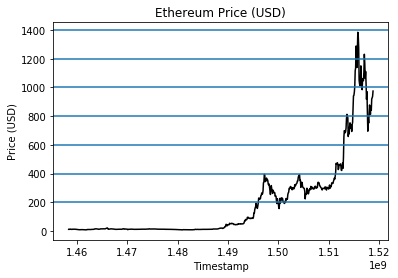

In [12]:
x1 = dfCC2['timestamp']
y1 = dfCC2['eth_close']

plt.plot(x1, y1, '-k', label='Actual')

for h1 in range(200, 1600, 200):
    plt.axhline(y=h1)

  
plt.title('Ethereum Price (USD)')
plt.xlabel("Timestamp")
plt.ylabel("Price (USD)")
    
plt.show()

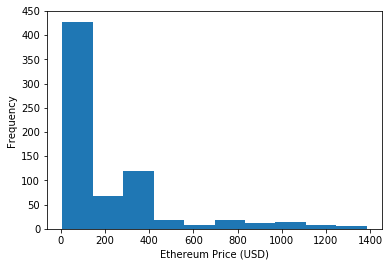

Standard deviation for closing price of Ethereum:  281.8130414031183


In [13]:
# Important Stats
x1 = dfCC2['timestamp']
y1 = dfCC2['eth_close']

plt.hist(y1)
plt.xlabel("Ethereum Price (USD)")
plt.ylabel("Frequency")
    
plt.show()
stdY1 = np.std(y1)
print('Standard deviation for closing price of Ethereum: ', stdY1)

In [14]:
dfCC2 = loadCryptosFeatures(365, dfCC2, lsCC, lsCCFeatures)

starting


100% (366 of 366) |#######################| Elapsed Time: 0:01:24 ETA:  0:00:00

# Prediction using Linear Regression

initialPredictionDate (inside (predictCryptoPrice):  2017-12-06 04:00:00
chunks: 10
1 :  2017-12-06 04:00:00
MSE:  9538.300570156718
Exp Var Score:  0.22514243380388144
2 :  2017-12-13 04:00:00


C:\Users\moust_000\AppData\Local\Programs\Python\Python35\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


MSE:  13790.026459346633
Exp Var Score:  -0.039598413424780654
3 :  2017-12-20 04:00:00
MSE:  2789.945098495006
Exp Var Score:  0.014236402841273588
4 :  2017-12-27 04:00:00
MSE:  4350.903816634796
Exp Var Score:  0.37602318829014736
5 :  2018-01-03 04:00:00
MSE:  168113.21105364696
Exp Var Score:  -1.1087456718212314
6 :  2018-01-10 04:00:00
MSE:  16792.041981479295
Exp Var Score:  0.06422192102425195
7 :  2018-01-17 04:00:00
MSE:  1744.1734548420015
Exp Var Score:  0.4948919893410505
8 :  2018-01-24 04:00:00
MSE:  37463.19226556062
Exp Var Score:  -1.1186349672738736
9 :  2018-01-31 04:00:00
MSE:  6218.2504576451265
Exp Var Score:  0.6155634167984649
10 :  2018-02-07 04:00:00
MSE:  8141.530776971381
Exp Var Score:  0.21096199498977186
InitialPredictionDate: 2017-12-06 04:00:00


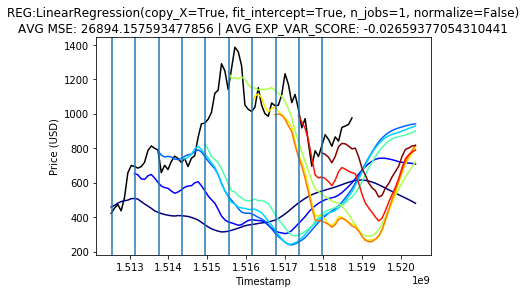

In [15]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
# regr = linear_model.LogisticRegression()

# from sklearn import tree
# regr = tree.DecisionTreeRegressor()

# from sklearn import svm
# regr = svm.SVR()

# from sklearn import ensemble
# regr = ensemble.RandomForestRegressor()

daysToPredict = 7
percentageOfTesting = 0.2

totalNumberOfDays, totalNumberOfChunks, initialPredictionDate, \
finalPredictionDate, MSE_list_avg, exp_var_score_list_avg, \
regr, dfCC_CC_X, dfCC_CC_y, dfCC_CC_X_train, dfCC_CC_y_train, dfCC_CC_X_test, dfCC_CC_y_test, \
dfCC_CC_X_test_before_list, dfCC_CC_y_test_before_list, dfCC_CC_X_test_after_list, \
dfCC_CC_y_test_after_list, dfCC_CC_X_test_list, dfCC_CC_y_test_list, \
dfCC_CC_y_test_after_1week_pred_list, dfCC_CC_X_test_after_1week_pred_list, \
dfCC_CC_y_test_after_1week_or_list, dfCC_CC_X_test_after_1week_or_list, \
MSE_list, exp_var_score_list = predictCryptoPrice(regr, daysToPredict,'eth', dfCC2, lsCCFeatures, percentageOfTesting)

print('InitialPredictionDate:', initialPredictionDate)

plotCCPredictions(regr, MSE_list_avg, exp_var_score_list_avg, initialPredictionDate, daysToPredict, totalNumberOfChunks, \
                      dfCC_CC_X_test_list, dfCC_CC_y_test_list, dfCC_CC_X_test_after_list, dfCC_CC_y_test_after_list)

# Prediction using BayesianRidge Regression

initialPredictionDate (inside (predictCryptoPrice):  2017-12-06 04:00:00
chunks: 10
1 :  2017-12-06 04:00:00


C:\Users\moust_000\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MSE:  10016.52183883698
Exp Var Score:  

C:\Users\moust_000\AppData\Local\Programs\Python\Python35\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


0.19899243262395983
2 :  2017-12-13 04:00:00
MSE:  16323.326983367248
Exp Var Score:  -0.0685888939752679
3 :  2017-12-20 04:00:00
MSE:  2990.4299754480303
Exp Var Score:  0.015644501281455225
4 :  2017-12-27 04:00:00
MSE:  5228.787105413178
Exp Var Score:  0.28610851053746655
5 :  2018-01-03 04:00:00
MSE:  166070.8907553049
Exp Var Score:  -1.0016353675650183
6 :  2018-01-10 04:00:00
MSE:  16591.863243995216
Exp Var Score:  0.08903134931568357
7 :  2018-01-17 04:00:00
MSE:  2237.4057622600308
Exp Var Score:  0.4624555763321401
8 :  2018-01-24 04:00:00
MSE:  39598.83287700703
Exp Var Score:  -1.1326047062233697
9 :  2018-01-31 04:00:00
MSE:  3945.8154904400662
Exp Var Score:  0.6967935846353255
10 :  2018-02-07 04:00:00
MSE:  10368.621429756242
Exp Var Score:  0.23865499963368852
InitialPredictionDate: 2017-12-06 04:00:00


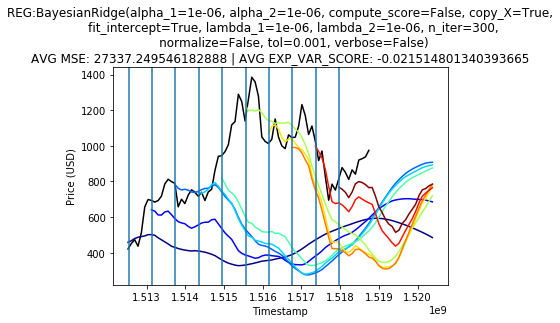

In [16]:
from sklearn import linear_model
regr = linear_model.BayesianRidge()
# regr = linear_model.LogisticRegression()

# from sklearn import tree
# regr = tree.DecisionTreeRegressor()

# from sklearn import svm
# regr = svm.SVR()

# from sklearn import ensemble
# regr = ensemble.RandomForestRegressor()

daysToPredict = 7
percentageOfTesting = 0.2

totalNumberOfDays, totalNumberOfChunks, initialPredictionDate, \
finalPredictionDate, MSE_list_avg, exp_var_score_list_avg, \
regr, dfCC_CC_X, dfCC_CC_y, dfCC_CC_X_train, dfCC_CC_y_train, dfCC_CC_X_test, dfCC_CC_y_test, \
dfCC_CC_X_test_before_list, dfCC_CC_y_test_before_list, dfCC_CC_X_test_after_list, \
dfCC_CC_y_test_after_list, dfCC_CC_X_test_list, dfCC_CC_y_test_list, \
dfCC_CC_y_test_after_1week_pred_list, dfCC_CC_X_test_after_1week_pred_list, \
dfCC_CC_y_test_after_1week_or_list, dfCC_CC_X_test_after_1week_or_list, \
MSE_list, exp_var_score_list = predictCryptoPrice(regr, daysToPredict,'eth', dfCC2, lsCCFeatures, percentageOfTesting)

print('InitialPredictionDate:', initialPredictionDate)

plotCCPredictions(regr, MSE_list_avg, exp_var_score_list_avg, initialPredictionDate, daysToPredict, totalNumberOfChunks, \
                      dfCC_CC_X_test_list, dfCC_CC_y_test_list, dfCC_CC_X_test_after_list, dfCC_CC_y_test_after_list)

# Prediction using RandomForestRegressor Regression

initialPredictionDate (inside (predictCryptoPrice):  2017-12-06 04:00:00
chunks: 10
1 : 

C:\Users\moust_000\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:49: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\moust_000\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:68: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\moust_000\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:68: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\moust_000\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:68: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,),

 2017-12-06 04:00:00
MSE:  31561.805270655797


C:\Users\moust_000\AppData\Local\Programs\Python\Python35\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\moust_000\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:49: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\moust_000\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:68: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\moust_000\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_lau

Exp Var Score:  0.0
2 :  2017-12-13 04:00:00
MSE:  135169.38560395254


C:\Users\moust_000\AppData\Local\Programs\Python\Python35\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\moust_000\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:49: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\moust_000\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:68: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\moust_000\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_lau

Exp Var Score:  2.220446049250313e-16
3 :  2017-12-20 04:00:00
MSE:  119518.65256109908
Exp Var Score:  0.0


C:\Users\moust_000\AppData\Local\Programs\Python\Python35\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\moust_000\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:49: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\moust_000\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:68: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\moust_000\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_lau

4 :  2017-12-27 04:00:00
MSE:  168159.8153617903
Exp Var Score:  

C:\Users\moust_000\AppData\Local\Programs\Python\Python35\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\moust_000\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:49: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\moust_000\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:68: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\moust_000\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_lau

0.0
5 :  2018-01-03 04:00:00
MSE:  540779.1631574297
Exp Var Score:  -2.220446049250313e-16

C:\Users\moust_000\AppData\Local\Programs\Python\Python35\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\moust_000\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:49: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\moust_000\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:68: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\moust_000\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_lau


6 :  2018-01-10 04:00:00
MSE:  718730.8689974068
Exp Var Score:  

C:\Users\moust_000\AppData\Local\Programs\Python\Python35\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\moust_000\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:49: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\moust_000\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:68: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\moust_000\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_lau

0.0
7 :  2018-01-17 04:00:00
MSE:  445311.41818079137

C:\Users\moust_000\AppData\Local\Programs\Python\Python35\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\moust_000\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:49: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\moust_000\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:68: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\moust_000\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_lau


Exp Var Score:  0.0
8 :  2018-01-24 04:00:00
MSE:  543723.9332941234
Exp Var Score: 

C:\Users\moust_000\AppData\Local\Programs\Python\Python35\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\moust_000\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:49: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\moust_000\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:68: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\moust_000\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_lau

 1.1102230246251565e-16
9 :  2018-01-31 04:00:00
MSE:  239732.18323203726
Exp Var Score:  

C:\Users\moust_000\AppData\Local\Programs\Python\Python35\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\moust_000\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:49: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\moust_000\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:68: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\moust_000\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_lau

1.1102230246251565e-16
10 :  2018-02-07 04:00:00
MSE:  229120.31091656158
Exp Var Score:  -2.220446049250313e-16
InitialPredictionDate: 2017-12-06 04:00:00


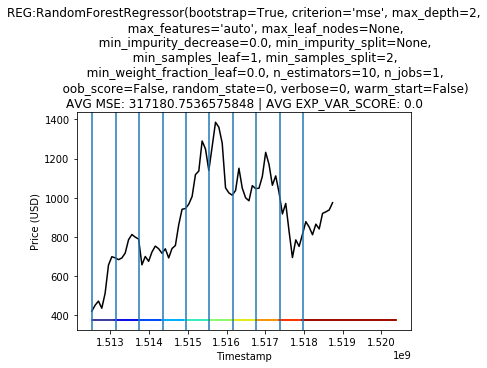

In [17]:
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor


# regr1 = DecisionTreeRegressor(max_depth=4)
regr = RandomForestRegressor(max_depth=2, random_state=0)
# regr = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
#                           n_estimators=300)

daysToPredict = 7
percentageOfTesting = 0.2

totalNumberOfDays, totalNumberOfChunks, initialPredictionDate, \
finalPredictionDate, MSE_list_avg, exp_var_score_list_avg, \
regr, dfCC_CC_X, dfCC_CC_y, dfCC_CC_X_train, dfCC_CC_y_train, dfCC_CC_X_test, dfCC_CC_y_test, \
dfCC_CC_X_test_before_list, dfCC_CC_y_test_before_list, dfCC_CC_X_test_after_list, \
dfCC_CC_y_test_after_list, dfCC_CC_X_test_list, dfCC_CC_y_test_list, \
dfCC_CC_y_test_after_1week_pred_list, dfCC_CC_X_test_after_1week_pred_list, \
dfCC_CC_y_test_after_1week_or_list, dfCC_CC_X_test_after_1week_or_list, \
MSE_list, exp_var_score_list = predictCryptoPrice(regr, daysToPredict,'eth', dfCC2, lsCCFeatures, percentageOfTesting)

print('InitialPredictionDate:', initialPredictionDate)

plotCCPredictions(regr, MSE_list_avg, exp_var_score_list_avg, initialPredictionDate, daysToPredict, totalNumberOfChunks, \
                      dfCC_CC_X_test_list, dfCC_CC_y_test_list, dfCC_CC_X_test_after_list, dfCC_CC_y_test_after_list)

# Prediction using Linear Ridge Regression

initialPredictionDate (inside (predictCryptoPrice):  2017-12-06 04:00:00
chunks: 10
1 :  2017-12-06 04:00:00
MSE:  9538.352825735918
Exp Var Score: 

C:\Users\moust_000\AppData\Local\Programs\Python\Python35\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


 0.22513955085717885
2 :  2017-12-13 04:00:00
MSE:  13790.293633320722
Exp Var Score:  -0.03960169020444604
3 :  2017-12-20 04:00:00
MSE:  2789.9677512733715
Exp Var Score:  0.01423691636496316
4 :  2017-12-27 04:00:00
MSE:  4350.987567793633
Exp Var Score:  0.3760136601265709
5 :  2018-01-03 04:00:00
MSE:  168112.99728553856
Exp Var Score:  -1.1087337218868782
6 :  2018-01-10 04:00:00
MSE:  16792.007871559174
Exp Var Score:  0.0642248097501964
7 :  2018-01-17 04:00:00
MSE:  1744.2177256948828
Exp Var Score:  0.4948891448623701
8 :  2018-01-24 04:00:00
MSE:  37463.43645578139
Exp Var Score:  -1.1186369444735278
9 :  2018-01-31 04:00:00
MSE:  6217.896132651587
Exp Var Score:  0.6155743138988539
10 :  2018-02-07 04:00:00
MSE:  8141.766637215811
Exp Var Score:  0.21097076804432713
InitialPredictionDate: 2017-12-06 04:00:00


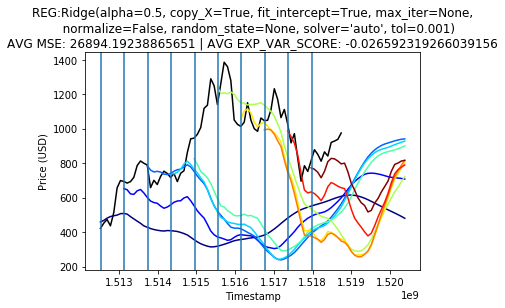

In [18]:
from sklearn import linear_model
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import AdaBoostRegressor
# from sklearn.ensemble import RandomForestRegressor


# regr1 = DecisionTreeRegressor(max_depth=4)
regr = linear_model.Ridge (alpha = .5)
# regr = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
#                           n_estimators=300)

daysToPredict = 7
percentageOfTesting = 0.2

totalNumberOfDays, totalNumberOfChunks, initialPredictionDate, \
finalPredictionDate, MSE_list_avg, exp_var_score_list_avg, \
regr, dfCC_CC_X, dfCC_CC_y, dfCC_CC_X_train, dfCC_CC_y_train, dfCC_CC_X_test, dfCC_CC_y_test, \
dfCC_CC_X_test_before_list, dfCC_CC_y_test_before_list, dfCC_CC_X_test_after_list, \
dfCC_CC_y_test_after_list, dfCC_CC_X_test_list, dfCC_CC_y_test_list, \
dfCC_CC_y_test_after_1week_pred_list, dfCC_CC_X_test_after_1week_pred_list, \
dfCC_CC_y_test_after_1week_or_list, dfCC_CC_X_test_after_1week_or_list, \
MSE_list, exp_var_score_list = predictCryptoPrice(regr, daysToPredict,'eth', dfCC2, lsCCFeatures, percentageOfTesting)

print('InitialPredictionDate:', initialPredictionDate)

plotCCPredictions(regr, MSE_list_avg, exp_var_score_list_avg, initialPredictionDate, daysToPredict, totalNumberOfChunks, \
                      dfCC_CC_X_test_list, dfCC_CC_y_test_list, dfCC_CC_X_test_after_list, dfCC_CC_y_test_after_list)

initialPredictionDate (inside (predictCryptoPrice):  2017-12-06 04:00:00
chunks: 10
1 :  2017-12-06 04:00:00
MSE:  9539.346065484537


C:\Users\moust_000\AppData\Local\Programs\Python\Python35\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Exp Var Score:  0.2250847582531761
2 :  2017-12-13 04:00:00
MSE:  13795.370462210854
Exp Var Score:  -0.03966403779126937
3 :  2017-12-20 04:00:00
MSE:  2790.397683191886
Exp Var Score:  0.014246565158443136
4 :  2017-12-27 04:00:00
MSE:  4352.579513953621
Exp Var Score:  0.37583259682117387
5 :  2018-01-03 04:00:00
MSE:  168108.9444677243
Exp Var Score:  -1.1085068435786347
6 :  2018-01-10 04:00:00
MSE:  16791.35995537105
Exp Var Score:  0.06427971570013491
7 :  2018-01-17 04:00:00
MSE:  1745.0586731449953
Exp Var Score:  0.4948349802612917
8 :  2018-01-24 04:00:00
MSE:  37468.08044392158
Exp Var Score:  -1.1186747530419812
9 :  2018-01-31 04:00:00
MSE:  6211.17190458604
Exp Var Score:  0.6157811744896027
10 :  2018-02-07 04:00:00
MSE:  8146.249493992106
Exp Var Score:  0.2111371547842582
InitialPredictionDate: 2017-12-06 04:00:00


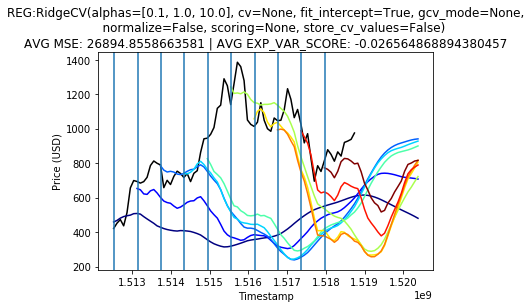

In [19]:
from sklearn import linear_model
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import AdaBoostRegressor
# from sklearn.ensemble import RandomForestRegressor


# regr1 = DecisionTreeRegressor(max_depth=4)
regr = linear_model.RidgeCV(alphas=[0.1, 1.0, 10.0])
# regr = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
#                           n_estimators=300)

daysToPredict = 7
percentageOfTesting = 0.2

totalNumberOfDays, totalNumberOfChunks, initialPredictionDate, \
finalPredictionDate, MSE_list_avg, exp_var_score_list_avg, \
regr, dfCC_CC_X, dfCC_CC_y, dfCC_CC_X_train, dfCC_CC_y_train, dfCC_CC_X_test, dfCC_CC_y_test, \
dfCC_CC_X_test_before_list, dfCC_CC_y_test_before_list, dfCC_CC_X_test_after_list, \
dfCC_CC_y_test_after_list, dfCC_CC_X_test_list, dfCC_CC_y_test_list, \
dfCC_CC_y_test_after_1week_pred_list, dfCC_CC_X_test_after_1week_pred_list, \
dfCC_CC_y_test_after_1week_or_list, dfCC_CC_X_test_after_1week_or_list, \
MSE_list, exp_var_score_list = predictCryptoPrice(regr, daysToPredict,'eth', dfCC2, lsCCFeatures, percentageOfTesting)

print('InitialPredictionDate:', initialPredictionDate)

plotCCPredictions(regr, MSE_list_avg, exp_var_score_list_avg, initialPredictionDate, daysToPredict, totalNumberOfChunks, \
                      dfCC_CC_X_test_list, dfCC_CC_y_test_list, dfCC_CC_X_test_after_list, dfCC_CC_y_test_after_list)

initialPredictionDate (inside (predictCryptoPrice):  2017-12-06 04:00:00
chunks: 10
1 :  2017-12-06 04:00:00


C:\Users\moust_000\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


MSE:  9551.261749263349


C:\Users\moust_000\AppData\Local\Programs\Python\Python35\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Exp Var Score:  0.22448902331348985
2 :  2017-12-13 04:00:00
MSE:  13839.187400266484
Exp Var Score:  -0.041346128864368614
3 :  2017-12-20 04:00:00
MSE:  2796.839640964048
Exp Var Score:  0.014461235533724248
4 :  2017-12-27 04:00:00
MSE:  4369.657015513399
Exp Var Score:  0.3738253072915627
5 :  2018-01-03 04:00:00
MSE:  167984.8399320871
Exp Var Score:  -1.1065888114690585
6 :  2018-01-10 04:00:00
MSE:  16792.36852770324
Exp Var Score:  0.06425726952160338
7 :  2018-01-17 04:00:00
MSE:  1744.7382595465263
Exp Var Score:  0.4936189740634145
8 :  2018-01-24 04:00:00
MSE:  37570.35275552872
Exp Var Score:  -1.1197217150613277
9 :  2018-01-31 04:00:00
MSE:  6148.586071411736
Exp Var Score:  0.6178058902790957
10 :  2018-02-07 04:00:00
MSE:  8184.789426934924
Exp Var Score:  0.21098302620668774
InitialPredictionDate: 2017-12-06 04:00:00


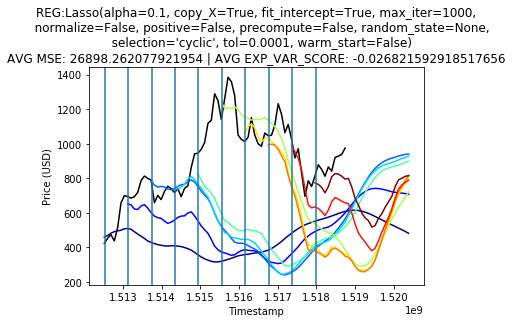

In [20]:
from sklearn import linear_model
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import AdaBoostRegressor
# from sklearn.ensemble import RandomForestRegressor


# regr1 = DecisionTreeRegressor(max_depth=4)
regr = linear_model.Lasso(alpha = 0.1)
# regr = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
#                           n_estimators=300)

daysToPredict = 7
percentageOfTesting = 0.2

totalNumberOfDays, totalNumberOfChunks, initialPredictionDate, \
finalPredictionDate, MSE_list_avg, exp_var_score_list_avg, \
regr, dfCC_CC_X, dfCC_CC_y, dfCC_CC_X_train, dfCC_CC_y_train, dfCC_CC_X_test, dfCC_CC_y_test, \
dfCC_CC_X_test_before_list, dfCC_CC_y_test_before_list, dfCC_CC_X_test_after_list, \
dfCC_CC_y_test_after_list, dfCC_CC_X_test_list, dfCC_CC_y_test_list, \
dfCC_CC_y_test_after_1week_pred_list, dfCC_CC_X_test_after_1week_pred_list, \
dfCC_CC_y_test_after_1week_or_list, dfCC_CC_X_test_after_1week_or_list, \
MSE_list, exp_var_score_list = predictCryptoPrice(regr, daysToPredict,'eth', dfCC2, lsCCFeatures, percentageOfTesting)

print('InitialPredictionDate:', initialPredictionDate)

plotCCPredictions(regr, MSE_list_avg, exp_var_score_list_avg, initialPredictionDate, daysToPredict, totalNumberOfChunks, \
                      dfCC_CC_X_test_list, dfCC_CC_y_test_list, dfCC_CC_X_test_after_list, dfCC_CC_y_test_after_list)

initialPredictionDate (inside (predictCryptoPrice):  2017-12-06 04:00:00
chunks: 10
1 :  2017-12-06 04:00:00
MSE:  17811.064654670765
Exp Var Score:  -0.08448915139399071

C:\Users\moust_000\AppData\Local\Programs\Python\Python35\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s



2 :  2017-12-13 04:00:00
MSE:  24694.69881821371
Exp Var Score:  -0.9951028574951124
3 :  2017-12-20 04:00:00
MSE:  3351.4535500589363
Exp Var Score:  -0.7496228969236756
4 :  2017-12-27 04:00:00
MSE:  20264.276783393107
Exp Var Score:  -0.7193513478703251
5 :  2018-01-03 04:00:00
MSE:  132473.05724983738
Exp Var Score:  -0.6641049200511389
6 :  2018-01-10 04:00:00
MSE:  21947.120750369104
Exp Var Score:  0.15414582787384568
7 :  2018-01-17 04:00:00
MSE:  10298.760340267558
Exp Var Score:  -0.4326681654142077
8 :  2018-01-24 04:00:00
MSE:  52133.85903960421
Exp Var Score:  -0.8218622903475938
9 :  2018-01-31 04:00:00
MSE:  18799.427454102177
Exp Var Score:  0.5334291128952549
10 :  2018-02-07 04:00:00
MSE:  10711.065924436274
Exp Var Score:  -0.4224416666547208
InitialPredictionDate: 2017-12-06 04:00:00


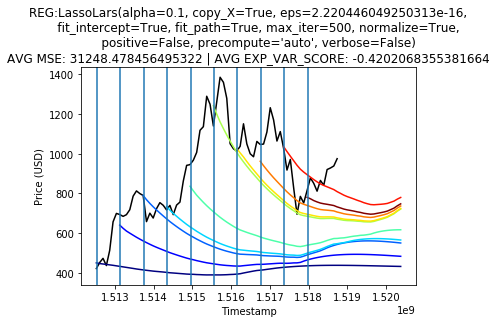

In [21]:
from sklearn import linear_model
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import AdaBoostRegressor
# from sklearn.ensemble import RandomForestRegressor


# regr1 = DecisionTreeRegressor(max_depth=4)
regr = linear_model.LassoLars(alpha=.1)
# regr = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
#                           n_estimators=300)

daysToPredict = 7
percentageOfTesting = 0.2

totalNumberOfDays, totalNumberOfChunks, initialPredictionDate, \
finalPredictionDate, MSE_list_avg, exp_var_score_list_avg, \
regr, dfCC_CC_X, dfCC_CC_y, dfCC_CC_X_train, dfCC_CC_y_train, dfCC_CC_X_test, dfCC_CC_y_test, \
dfCC_CC_X_test_before_list, dfCC_CC_y_test_before_list, dfCC_CC_X_test_after_list, \
dfCC_CC_y_test_after_list, dfCC_CC_X_test_list, dfCC_CC_y_test_list, \
dfCC_CC_y_test_after_1week_pred_list, dfCC_CC_X_test_after_1week_pred_list, \
dfCC_CC_y_test_after_1week_or_list, dfCC_CC_X_test_after_1week_or_list, \
MSE_list, exp_var_score_list = predictCryptoPrice(regr, daysToPredict,'eth', dfCC2, lsCCFeatures, percentageOfTesting)

print('InitialPredictionDate:', initialPredictionDate)

plotCCPredictions(regr, MSE_list_avg, exp_var_score_list_avg, initialPredictionDate, daysToPredict, totalNumberOfChunks, \
                      dfCC_CC_X_test_list, dfCC_CC_y_test_list, dfCC_CC_X_test_after_list, dfCC_CC_y_test_after_list)

In [22]:
# from sklearn import linear_model
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import AdaBoostRegressor
# from sklearn.ensemble import RandomForestRegressor


# # regr1 = DecisionTreeRegressor(max_depth=4)
# # regr = RandomForestRegressor(max_depth=100, random_state=0)
# # regr = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
# #                           n_estimators=300)

# from sklearn.model_selection import RandomizedSearchCV
# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]
# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}
# # pprint(random_grid)

# # regr = RandomForestRegressor(max_depth=100, random_state=0)
# rf = RandomForestRegressor()
# regr = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# # regr.fit()


# daysToPredict = 7
# percentageOfTesting = 0.2

# totalNumberOfDays, totalNumberOfChunks, initialPredictionDate, \
# finalPredictionDate, MSE_list_avg, exp_var_score_list_avg, \
# regr, dfCC_CC_X, dfCC_CC_y, dfCC_CC_X_train, dfCC_CC_y_train, dfCC_CC_X_test, dfCC_CC_y_test, \
# dfCC_CC_X_test_before_list, dfCC_CC_y_test_before_list, dfCC_CC_X_test_after_list, \
# dfCC_CC_y_test_after_list, dfCC_CC_X_test_list, dfCC_CC_y_test_list, \
# dfCC_CC_y_test_after_1week_pred_list, dfCC_CC_X_test_after_1week_pred_list, \
# dfCC_CC_y_test_after_1week_or_list, dfCC_CC_X_test_after_1week_or_list, \
# MSE_list, exp_var_score_list = predictCryptoPrice(regr, daysToPredict,'eth', dfCC2, lsCCFeatures, percentageOfTesting)

# print('InitialPredictionDate:', initialPredictionDate)

# plotCCPredictions(regr, MSE_list_avg, exp_var_score_list_avg, initialPredictionDate, daysToPredict, totalNumberOfChunks, \
#                       dfCC_CC_X_test_list, dfCC_CC_y_test_list, dfCC_CC_X_test_after_list, dfCC_CC_y_test_after_list)

# print(regr.best_params_)

# Optimization
In this section we selected the ridge lasso algorithm and we will try to optimize the algorithm performance by tweaking the related hyperparameters

#### Trial #1: alpha=0.5 / max_iter=10000 / precompute=True

initialPredictionDate (inside (predictCryptoPrice):  2017-12-06 04:00:00
chunks: 10
1 :  2017-12-06 04:00:00
MSE:  9585.44868316763
Exp Var Score:  

C:\Users\moust_000\AppData\Local\Programs\Python\Python35\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


0.2226783669720649
2 :  2017-12-13 04:00:00
MSE:  13842.344791057714
Exp Var Score:  -0.045245112378808905
3 :  2017-12-20 04:00:00
MSE:  2838.8436202300304
Exp Var Score:  0.014679073914066643
4 :  2017-12-27 04:00:00
MSE:  4418.564767187681
Exp Var Score:  0.3678582683700935
5 :  2018-01-03 04:00:00
MSE:  167421.96029451856
Exp Var Score:  -1.100851366677757
6 :  2018-01-10 04:00:00
MSE:  16774.43884735877
Exp Var Score:  0.06508525521815867
7 :  2018-01-17 04:00:00
MSE:  1730.150934663667
Exp Var Score:  0.4880707635645515
8 :  2018-01-24 04:00:00
MSE:  37985.73373265013
Exp Var Score:  -1.1262165542943374
9 :  2018-01-31 04:00:00
MSE:  6012.050069293641
Exp Var Score:  0.6230433957274166
10 :  2018-02-07 04:00:00
MSE:  8351.476826616137
Exp Var Score:  0.2200336817925086
InitialPredictionDate: 2017-12-06 04:00:00


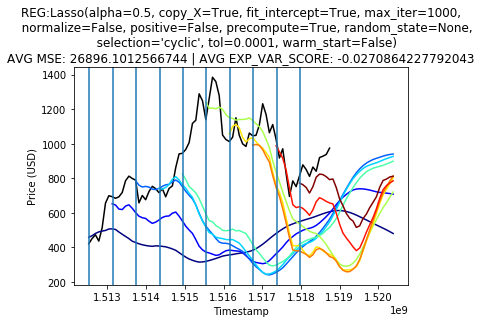

In [23]:
from sklearn import linear_model
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import AdaBoostRegressor
# from sklearn.ensemble import RandomForestRegressor


# regr1 = DecisionTreeRegressor(max_depth=4)
regr = linear_model.Lasso(alpha = 0.5, max_iter=1000, precompute=True)
# regr = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
#                           n_estimators=300)

daysToPredict = 7
percentageOfTesting = 0.2

totalNumberOfDays, totalNumberOfChunks, initialPredictionDate, \
finalPredictionDate, MSE_list_avg, exp_var_score_list_avg, \
regr, dfCC_CC_X, dfCC_CC_y, dfCC_CC_X_train, dfCC_CC_y_train, dfCC_CC_X_test, dfCC_CC_y_test, \
dfCC_CC_X_test_before_list, dfCC_CC_y_test_before_list, dfCC_CC_X_test_after_list, \
dfCC_CC_y_test_after_list, dfCC_CC_X_test_list, dfCC_CC_y_test_list, \
dfCC_CC_y_test_after_1week_pred_list, dfCC_CC_X_test_after_1week_pred_list, \
dfCC_CC_y_test_after_1week_or_list, dfCC_CC_X_test_after_1week_or_list, \
MSE_list, exp_var_score_list = predictCryptoPrice(regr, daysToPredict,'eth', dfCC2, lsCCFeatures, percentageOfTesting)

print('InitialPredictionDate:', initialPredictionDate)

plotCCPredictions(regr, MSE_list_avg, exp_var_score_list_avg, initialPredictionDate, daysToPredict, totalNumberOfChunks, \
                      dfCC_CC_X_test_list, dfCC_CC_y_test_list, dfCC_CC_X_test_after_list, dfCC_CC_y_test_after_list)

From the above graph, we can see a minor enhancement of performance (MSE = 26896 VS the old MSE of 26898) 

#### Trial #2: alpha=0.7 / max_iter=10000 / precompute=True

initialPredictionDate (inside (predictCryptoPrice):  2017-12-06 04:00:00
chunks: 10
1 :  2017-12-06 04:00:00
MSE:  9611.90494688057
Exp Var Score:  

C:\Users\moust_000\AppData\Local\Programs\Python\Python35\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


0.22130853243917337
2 :  2017-12-13 04:00:00
MSE:  13946.90658198268
Exp Var Score:  -0.0488450534630096
3 :  2017-12-20 04:00:00
MSE:  2853.872237728499
Exp Var Score:  0.015333620905230494
4 :  2017-12-27 04:00:00
MSE:  4458.729536595351
Exp Var Score:  0.3632304209873246
5 :  2018-01-03 04:00:00
MSE:  167176.4721943663
Exp Var Score:  -1.0961772921634738
6 :  2018-01-10 04:00:00
MSE:  16774.352728538226
Exp Var Score:  0.06526459695645848
7 :  2018-01-17 04:00:00
MSE:  1734.3829359303093
Exp Var Score:  0.48550858152911947
8 :  2018-01-24 04:00:00
MSE:  38200.96725700405
Exp Var Score:  -1.1281965767082425
9 :  2018-01-31 04:00:00
MSE:  5872.110531581917
Exp Var Score:  0.6276531774256953
10 :  2018-02-07 04:00:00
MSE:  8451.623935953156
Exp Var Score:  0.22056048295109354
InitialPredictionDate: 2017-12-06 04:00:00


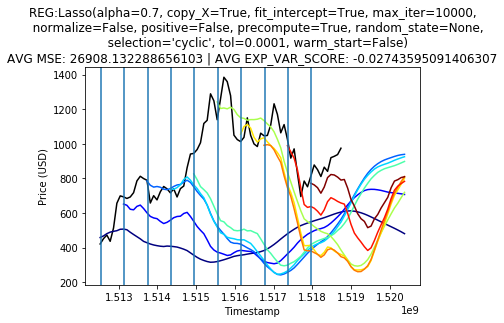

In [24]:
from sklearn import linear_model
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import AdaBoostRegressor
# from sklearn.ensemble import RandomForestRegressor


# regr1 = DecisionTreeRegressor(max_depth=4)
regr = linear_model.Lasso(alpha = 0.7, max_iter=10000, precompute=True)
# regr = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
#                           n_estimators=300)

daysToPredict = 7
percentageOfTesting = 0.2

totalNumberOfDays, totalNumberOfChunks, initialPredictionDate, \
finalPredictionDate, MSE_list_avg, exp_var_score_list_avg, \
regr, dfCC_CC_X, dfCC_CC_y, dfCC_CC_X_train, dfCC_CC_y_train, dfCC_CC_X_test, dfCC_CC_y_test, \
dfCC_CC_X_test_before_list, dfCC_CC_y_test_before_list, dfCC_CC_X_test_after_list, \
dfCC_CC_y_test_after_list, dfCC_CC_X_test_list, dfCC_CC_y_test_list, \
dfCC_CC_y_test_after_1week_pred_list, dfCC_CC_X_test_after_1week_pred_list, \
dfCC_CC_y_test_after_1week_or_list, dfCC_CC_X_test_after_1week_or_list, \
MSE_list, exp_var_score_list = predictCryptoPrice(regr, daysToPredict,'eth', dfCC2, lsCCFeatures, percentageOfTesting)

print('InitialPredictionDate:', initialPredictionDate)

plotCCPredictions(regr, MSE_list_avg, exp_var_score_list_avg, initialPredictionDate, daysToPredict, totalNumberOfChunks, \
                      dfCC_CC_X_test_list, dfCC_CC_y_test_list, dfCC_CC_X_test_after_list, dfCC_CC_y_test_after_list)

#### Trial #3: Lasso with alpha=0.5 / max_iter=100000 / precompute=True

initialPredictionDate (inside (predictCryptoPrice):  2017-12-06 04:00:00
chunks: 10
1 :  2017-12-06 04:00:00
MSE:  9585.44868316763
Exp Var Score:  

C:\Users\moust_000\AppData\Local\Programs\Python\Python35\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


0.2226783669720649
2 :  2017-12-13 04:00:00
MSE:  13842.344791057714
Exp Var Score:  -0.045245112378808905
3 :  2017-12-20 04:00:00
MSE:  2838.8436202300304
Exp Var Score:  0.014679073914066643
4 :  2017-12-27 04:00:00
MSE:  4418.564767187681
Exp Var Score:  0.3678582683700935
5 :  2018-01-03 04:00:00
MSE:  167421.96029451856
Exp Var Score:  -1.100851366677757
6 :  2018-01-10 04:00:00
MSE:  16774.43884735877
Exp Var Score:  0.06508525521815867
7 :  2018-01-17 04:00:00
MSE:  1730.150934663667
Exp Var Score:  0.4880707635645515
8 :  2018-01-24 04:00:00
MSE:  37985.73373265013
Exp Var Score:  -1.1262165542943374
9 :  2018-01-31 04:00:00
MSE:  6012.050069293641
Exp Var Score:  0.6230433957274166
10 :  2018-02-07 04:00:00
MSE:  8351.476826616137
Exp Var Score:  0.2200336817925086
InitialPredictionDate: 2017-12-06 04:00:00


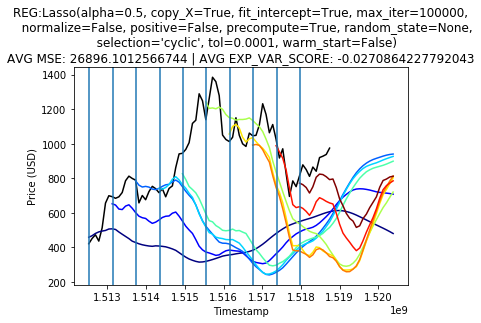

In [25]:
from sklearn import linear_model
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import AdaBoostRegressor
# from sklearn.ensemble import RandomForestRegressor


# regr1 = DecisionTreeRegressor(max_depth=4)
regr = linear_model.Lasso(alpha = 0.5, max_iter=100000, precompute=True)
# regr = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
#                           n_estimators=300)

daysToPredict = 7
percentageOfTesting = 0.2

totalNumberOfDays, totalNumberOfChunks, initialPredictionDate, \
finalPredictionDate, MSE_list_avg, exp_var_score_list_avg, \
regr, dfCC_CC_X, dfCC_CC_y, dfCC_CC_X_train, dfCC_CC_y_train, dfCC_CC_X_test, dfCC_CC_y_test, \
dfCC_CC_X_test_before_list, dfCC_CC_y_test_before_list, dfCC_CC_X_test_after_list, \
dfCC_CC_y_test_after_list, dfCC_CC_X_test_list, dfCC_CC_y_test_list, \
dfCC_CC_y_test_after_1week_pred_list, dfCC_CC_X_test_after_1week_pred_list, \
dfCC_CC_y_test_after_1week_or_list, dfCC_CC_X_test_after_1week_or_list, \
MSE_list, exp_var_score_list = predictCryptoPrice(regr, daysToPredict,'eth', dfCC2, lsCCFeatures, percentageOfTesting)

print('InitialPredictionDate:', initialPredictionDate)

plotCCPredictions(regr, MSE_list_avg, exp_var_score_list_avg, initialPredictionDate, daysToPredict, totalNumberOfChunks, \
                      dfCC_CC_X_test_list, dfCC_CC_y_test_list, dfCC_CC_X_test_after_list, dfCC_CC_y_test_after_list)

In [26]:
#### Trial #4: Lasso with alpha=0.2 / max_iter=100000 / precompute=True

initialPredictionDate (inside (predictCryptoPrice):  2017-12-06 04:00:00
chunks: 10
1 :  2017-12-06 04:00:00
MSE:  9554.87490246672
Exp Var Score:  0.2241605786486366


C:\Users\moust_000\AppData\Local\Programs\Python\Python35\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


2 :  2017-12-13 04:00:00
MSE:  13808.245405660486
Exp Var Score:  -0.04058347177495625
3 :  2017-12-20 04:00:00
MSE:  2809.394059340656
Exp Var Score:  0.01496127348193732
4 :  2017-12-27 04:00:00
MSE:  4378.932904414983
Exp Var Score:  0.3727349073892491
5 :  2018-01-03 04:00:00
MSE:  167836.31322729678
Exp Var Score:  -1.104956124561805
6 :  2018-01-10 04:00:00
MSE:  16786.31020481705
Exp Var Score:  0.0644971083032202
7 :  2018-01-17 04:00:00
MSE:  1743.6401560468846
Exp Var Score:  0.492555559655111
8 :  2018-01-24 04:00:00
MSE:  37662.689268530194
Exp Var Score:  -1.1218438046235688
9 :  2018-01-31 04:00:00
MSE:  6131.533172680322
Exp Var Score:  0.6185596019028886
10 :  2018-02-07 04:00:00
MSE:  8247.639312391604
Exp Var Score:  0.21549742737496558
InitialPredictionDate: 2017-12-06 04:00:00


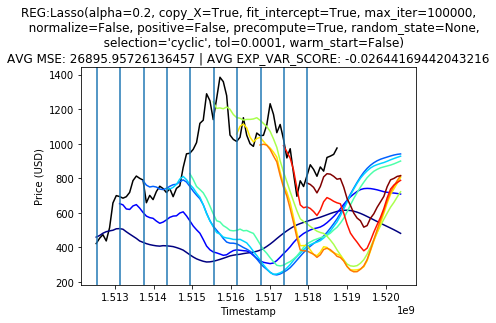

In [27]:
from sklearn import linear_model
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import AdaBoostRegressor
# from sklearn.ensemble import RandomForestRegressor


# regr1 = DecisionTreeRegressor(max_depth=4)
regr = linear_model.Lasso(alpha = 0.2, max_iter=100000, precompute=True)
# regr = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
#                           n_estimators=300)

daysToPredict = 7
percentageOfTesting = 0.2

totalNumberOfDays, totalNumberOfChunks, initialPredictionDate, \
finalPredictionDate, MSE_list_avg, exp_var_score_list_avg, \
regr, dfCC_CC_X, dfCC_CC_y, dfCC_CC_X_train, dfCC_CC_y_train, dfCC_CC_X_test, dfCC_CC_y_test, \
dfCC_CC_X_test_before_list, dfCC_CC_y_test_before_list, dfCC_CC_X_test_after_list, \
dfCC_CC_y_test_after_list, dfCC_CC_X_test_list, dfCC_CC_y_test_list, \
dfCC_CC_y_test_after_1week_pred_list, dfCC_CC_X_test_after_1week_pred_list, \
dfCC_CC_y_test_after_1week_or_list, dfCC_CC_X_test_after_1week_or_list, \
MSE_list, exp_var_score_list = predictCryptoPrice(regr, daysToPredict,'eth', dfCC2, lsCCFeatures, percentageOfTesting)

print('InitialPredictionDate:', initialPredictionDate)

plotCCPredictions(regr, MSE_list_avg, exp_var_score_list_avg, initialPredictionDate, daysToPredict, totalNumberOfChunks, \
                      dfCC_CC_X_test_list, dfCC_CC_y_test_list, dfCC_CC_X_test_after_list, dfCC_CC_y_test_after_list)

In [160]:
### Checking the robsutness and accuracy of the Lasso model from Trial #4
import random

print ('Row\t', 'Predicted\t\t', 'Actual\t', '\tError (%)')
for x in range(5):
    rowIndex = random.randint(1,60)
    X1 = dfCC_CC_X_test.iloc[rowIndex:rowIndex+1,1:]
    y1Actual = float(dfCC_CC_y_test.iloc[rowIndex:rowIndex+1,1:].eth_close_after_1day)
    y1Predict = regr.predict(X1)[0]
    print(rowIndex,'\t', y1Predict, '\t', y1Actual, '\t', abs((y1Actual-y1Predict)/y1Actual)*100)

Row	 Predicted		 Actual	 	Error (%)
43 	 1070.1371127129685 	 1037.36 	 3.159666144151363
50 	 1063.0087692439051 	 1048.58 	 1.3760294153908341
11 	 712.7761144421363 	 785.99 	 9.314862219349319
56 	 988.1472847918471 	 1026.19 	 3.707180464451311
45 	 1018.7533842553498 	 1049.09 	 2.89170764611712


# Conclusion
As can be seen in the previous sections and after optimizing the hyperparameters of the Lasso linear regression model, we can see that the regression model with the hyper parameters (Trial #4: Lasso with alpha=0.2 / max_iter=100000 / precompute=True) gave the best MSE value and therefore this can be selected as the best optimized model.